# 決定木

## 決定木とは

回帰などの線形モデルやSVMでは、そのモデルがどのように分類されたかわからない分類過程がブラックボックスの手法でした。

しかし、ときには分類過程を知ることが必要になります。

例えば、メールがスパムメールかそうでないかを分類する例を考えると

今までの学習手法だとどの単語によってスパムメールと判断されたかがわかりません。

なので、スパムメールに含まれる単語を見つけるには分類過程を知る必要があります。

今回学習する決定木の一番の特徴は、分類過程が明瞭ということです。

決定木はとても単純な手法ですが、非常に効果的な教師あり学習手法です。

決定木の簡単な例を示します。

最初に、そのメールの文書に「無料」という単語が含まれているかを問います。

もし、含まれているならそのメールはスパムと分類されます。

含まれていないなら、さらにそのメールは連絡先に入っている人から来たかという質問をします。

それが、Yesならばスパムメールではない、Noならスパムメールと分類されます。

このように決定木は人が理解するのに容易で、何がその分類を決定づけたかが分かります。

In [1]:
#csvファイルを読み込む
import csv
import numpy as np

with open('./titanic.csv', 'r') as csvfile:
    titanic_reader  = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    #特徴量の名前が書かれたheaderを読み込む
    row = next(titanic_reader)
    feature_names = np.array(row)
    
    #データと正解ラベルを読み取る
    titanic_x, titanic_y = [], []
    for row in titanic_reader:
        titanic_x.append(row)
        titanic_y.append(row[2]) #正解ラベルがあるのは3列目の”survived”
     
    #型をリストからnumpy.ndarrayにする
    titanic_x = np.array(titanic_x)
    titanic_y = np.array(titanic_y)

print(feature_names)
print(titanic_x[0], titanic_y[0])

['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']
['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1


## 前処理
<p>最初に使う特徴量を選択する</p>

前処理とは生データを数値で表した特徴量にすること。

テキストデータは役に立たないので意味のある数値に変換できて
始めてクラスタリング等の機械学習アルゴリズムに入力することができる

特徴量→説明変数

今回は特徴量として「クラス」「年齢」「性別」を使用する。

In [2]:
#pclass(1), age(4), sex(10)を残して、あとは消す
titanic_x = titanic_x[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]

print(feature_names)
print(titanic_x)

['pclass' 'age' 'sex']
[['1st' '29.0000' 'female']
 ['1st' ' 2.0000' 'female']
 ['1st' '30.0000' 'male']
 ..., 
 ['3rd' 'NA' 'male']
 ['3rd' 'NA' 'female']
 ['3rd' 'NA' 'male']]


## 欠損値の補完
出力した13番目のデータを見ると、ageが'NA'となっています。

これはデータがNot Available、すなわち存在しないということを表しており欠損値と呼ばれます。

欠損値があると学習できないため(scikit-learnでモデルを作れないため)、今回は欠損値を年齢の平均値に置き換えます。

（欠損値を埋めるために最頻値や中央値を用いることもあります）

In [3]:
# 年齢の欠損値を平均値で埋める
ages = titanic_x[:,1]
# NA以外のageの平均値を計算する
mean_age = np.mean(titanic_x[ages != 'NA', 1].astype(float))
# ageがNAのものを平均値に置き換える
titanic_x[titanic_x[:,1]=='NA', 1] = mean_age
titanic_x

array([['1st', '29.0000', 'female'],
       ['1st', ' 2.0000', 'female'],
       ['1st', '30.0000', 'male'],
       ..., 
       ['3rd', '31.19418104265403', 'male'],
       ['3rd', '31.19418104265403', 'female'],
       ['3rd', '31.19418104265403', 'male']],
      dtype='<U62')

## Label Encoder

また、出力した13番目のデータのsexは'female'と文字列となっています。

文字列のデータのことをカテゴリカルデータといいます。

学習するためには、文字列を数値に修正する必要があります。

そこで、LabelEncoder()を使って数値に直します。

数値に直すというのは、

'female' → 0

'male' → 1

にするということです。

In [4]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x[:, 2])
print('Categorical classes:' , label_encoder.classes_)

Categorical classes: ['female' 'male']


In [5]:
integer_classes = label_encoder.transform(label_encoder.classes_)
print('Integer classes:', integer_classes)

Integer classes: [0 1]


In [6]:
t = label_encoder.transform(titanic_x[:,2])
titanic_x[:,2] = t

print(feature_names)
print(titanic_x[12], titanic_y[12])

['pclass' 'age' 'sex']
['1st' '31.19418104265403' '0'] 1


実行すると、

['pclass' 'age' 'sex']

['1st' '31.19418104265403' '0'] 1

と出力され、'female'が0になっていることが分かります。


## OneHotEncoder
先程は、'sex'を0,1に変更しました。

しかし、pclassもカテゴリカルデータなので数値に修正する必要があります。

ただし、ageと同様の手法で

1st →　0

2nd →　1

3rd →　2

としてはいけません。

なぜなら、カテゴリカルデータでは順序性がなく1st < 2nd < 3rdという関係が成り立たないからです。

これを、数値の1, 2, 3としてしまうと1 < 2 < 3という関係になってしまいおかしくなっています。

そこで、**OneHotEncoder**という手法を用います。

これは、それぞれのデータに対し当てはまれば「１」当てはまなければ「０」とするものです。

pclassに対し、OneHotEncoderを行ってみる

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x[:, 0])
print("Categorical classes:", label_encoder.classes_)

Categorical classes: ['1st' '2nd' '3rd']


In [8]:
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3,1)
print('Integrer classes:', integer_classes)

Integrer classes: [[0]
 [1]
 [2]]


In [9]:
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)

# 最初に、Label Encoderを使ってpclassを0-2に直す
num_of_rows = titanic_x.shape[0]
num_of_rows

1313

In [10]:
t = label_encoder.transform(titanic_x[:,0]).reshape(num_of_rows, 1)
t

array([[0],
       [0],
       [0],
       ..., 
       [2],
       [2],
       [2]], dtype=int64)

In [11]:
# 次に、OneHotEncoderをつかってデータを1，0に変換
new_features = one_hot_encoder.transform(t)
new_features.shape

(1313, 3)

In [12]:
#1,0になおしてデータを統合する
titanic_x = np.concatenate([titanic_x, new_features.toarray()], axis = 1)
titanic_x

array([['1st', '29.0000', '0', '1.0', '0.0', '0.0'],
       ['1st', ' 2.0000', '0', '1.0', '0.0', '0.0'],
       ['1st', '30.0000', '1', '1.0', '0.0', '0.0'],
       ..., 
       ['3rd', '31.19418104265403', '1', '0.0', '0.0', '1.0'],
       ['3rd', '31.19418104265403', '0', '0.0', '0.0', '1.0'],
       ['3rd', '31.19418104265403', '1', '0.0', '0.0', '1.0']],
      dtype='<U62')

In [13]:
#one_hot_ encoderをする前のpclassのデータを削除する
titanic_x = np.delete(titanic_x, [0], 1)
titanic_x

array([['29.0000', '0', '1.0', '0.0', '0.0'],
       [' 2.0000', '0', '1.0', '0.0', '0.0'],
       ['30.0000', '1', '1.0', '0.0', '0.0'],
       ..., 
       ['31.19418104265403', '1', '0.0', '0.0', '1.0'],
       ['31.19418104265403', '0', '0.0', '0.0', '1.0'],
       ['31.19418104265403', '1', '0.0', '0.0', '1.0']],
      dtype='<U62')

In [14]:
#特徴量の名前を更新する
feature_names = ['age','sex','first class','second class','third class']

#Conver to numerical values
titanic_x = titanic_x.astype(float)
titanic_y = titanic_y.astype(float)

print(feature_names)
print(titanic_x[0], titanic_y[0])

['age', 'sex', 'first class', 'second class', 'third class']
[ 29.   0.   1.   0.   0.] 1.0


これで学習する準備終わった。前処理終了

## 学習
学習データとテストデータに分ける
その後、scikit-learnのDecision Tree Classifierを使って学習する

In [15]:
from sklearn.cross_validation import train_test_split
X_train, x_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.25, random_state=33)

# scikit_learnのDecision Tree Classifierを使って学習する

from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf = 5)
clf = clf.fit(X_train, y_train)

#今回はパラメータとしてcriterion, max_depth, min_samples_leafを指定する
"""
criterion : 分類基準(entropy と　giniがある)
max_depth : 木の深さ
min_samples_split : 分割するときに必要なデータ数
"""

C:\Users\masayoshi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\ncriterion : 分類基準(entropy と\u3000giniがある)\nmax_depth : 木の深さ\nmin_samples_split : 分割するときに必要なデータ数\n'

これ以外のパラメータを設定したいとき、scikit-learnのHPを参考にしてみましょう。 

これで学習ができました。

では、学習した結果を可視化してみましょう。

決定木を可視化するには、***Graphviz***と***pydotplus***が必要になります。

ターミナル（コマンドプロンプト）からinstallしましょう。

pip install Graphviz

pip install pydotplus

*できない場合はこちらからinstallしてください。

またInvocationException: GraphViz's executables not foundというエラーで可視化ができない場合は、

brew install graphviz
pip install -U pydotplus 

としてください。
ダウンロードサイト1
ダウンロードサイト2

※上記の方法かつWindowsで出来ない場合は、ネットの情報を参考にしてみてください。

そして、以下のプログラムを入力すると木が出力されます。

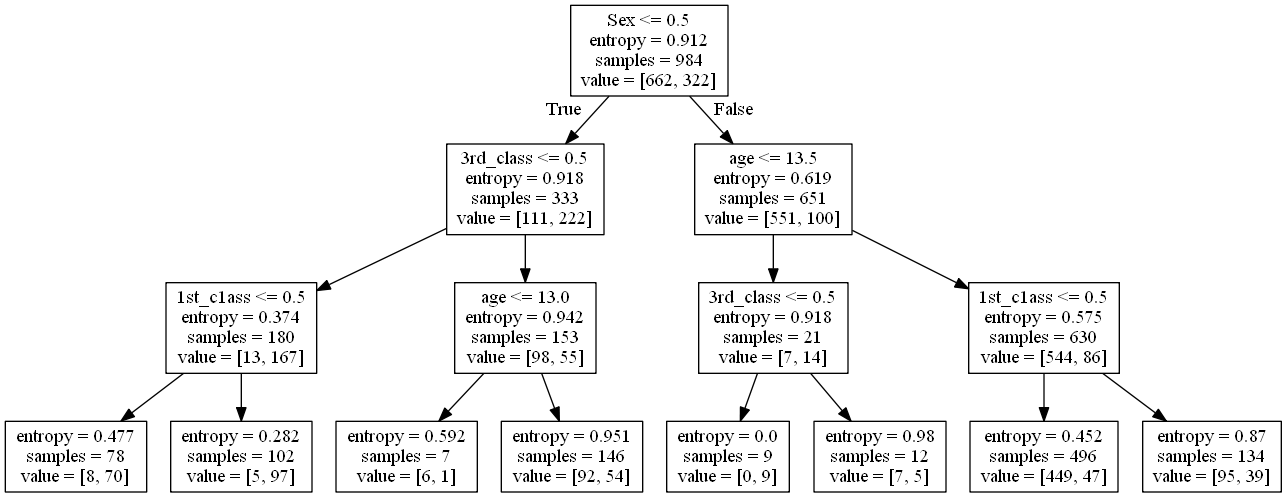

In [18]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names = ['age','Sex','1st_c1ass','2nd_class','3rd_class'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("tree.png")
Image(graph.create_png())

In [20]:
measure_performance(x_train, y_train, clf)

NameError: name 'measure_performance' is not defined

この木は、学習データによる学習結果を表しています。

質問を答えることによって、分類がされます。

例えば、一番上の部分では

sex <= 0.5か？ということを聞いています。

（sexは'woman'か？）

このとき、答えがyesなら左へ、Noなら右へ進みます。

進んだ先の質問にも答え、同様にyesなら左へ,Noなら右に行きます。

これを最下段まで繰り返し、最下段と多数のほうの正解ラベルがふられます。

sex <= 0.5 （sexは'woman'か）　→　yes

3rd_class <= 0.5 (3rd_classではない）　→　yes

1st_class <= 0.5 (1st_classではない）　→　yes

と進んだとき、最後はValue = [8, 70]となっており、生き延びた人のほうが多い
です。

なので、性別が女性で、2nd classにいた人は生き延びたと分類されます。

では、first classにいた10才の女の子はどちらに分類されるか自分で考えてみましょう。

答えは、”生き延びた”です。

では、最後に精度を確認してみましょう。

measure_performance(x_train, y_train, clf)

実行すると、

Accuracy:0.838 
Classification report
precision recall f1-score support
0.0 0.82 0.98 0.89 662
1.0 0.93 0.55 0.69 322
avg / total 0.85 0.84 0.82 984
Confussion matrix

[[649 13]
[146 176]] 
と出力され良い分類ができていることが分かります。

# 今回作成したプログラム

In [21]:
import csv
import numpy as np

with open('./titanic.csv','r') as csvfile:
    titanic_reader = csv.reader(csvfile,delimiter=',',quotechar='"')

    #特徴量の名前が書かれたHeaderを読み取る
    row = next(titanic_reader)
    feature_names = np.array(row)

    #データと正解ラベルを読み取る
    titanic_x, titanic_y = [],[]
    for row in titanic_reader:
        titanic_x.append(row)
        titanic_y.append(row[2]) #正解ラベルは3列目の"survived"

    titanic_x = np.array(titanic_x) #型をリストからnumpy.ndarrayにする
    titanic_y = np.array(titanic_y) #型をリストからnumpy.ndarrayにする

print(feature_names)
print(titanic_x[0],titanic_y[0])


#class(1),age(4),sex(10)を残す
titanic_x = titanic_x[:,[1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]

print(feature_names)
print(titanic_x[12],titanic_y[12])


#年齢の欠損値を平均値で埋める
ages = titanic_x[:,1]
#NA以外のageの平均値を計算する
mean_age = np.mean(titanic_x[ages != 'NA',1].astype(float))
#ageがNAのものを平均値に置き換える
titanic_x[titanic_x[:, 1] == 'NA',1] =mean_age


from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x[:, 2])
print('Cateorical classes:',label_encoder.classes_)

integer_classes = label_encoder.transform(label_encoder.classes_)
print('Integer classes:',integer_classes)

t = label_encoder.transform(titanic_x[:, 2])
titanic_x[:,2] = t

print(feature_names)
print(titanic_x[12],titanic_y[12])


from sklearn.preprocessing import OneHotEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x [:, 0])
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1)
print("Integer classes:", integer_classes)
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)

#最初に、Label Encoderを使ってpclassを0-2に直す
num_of_rows = titanic_x.shape[0]
t = label_encoder.transform(titanic_x[:, 0]).reshape(num_of_rows, 1)
#次に、OneHotEncoderを使ってデータを1, 0に変換
new_features = one_hot_encoder.transform(t)
#1,0になおしてデータを統合する
titanic_x = np.concatenate([titanic_x, new_features.toarray()], axis = 1)
#OnehotEncoderをする前のpclassのデータを削除する
titanic_x = np.delete(titanic_x, [0], 1)
#特徴量の名前を更新する
feature_names = ['age', 'sex', 'first class', 'second class', 'third class']

# Convert to numerical values
titanic_x = titanic_x.astype (float)
titanic_y = titanic_y.astype (float)

print(feature_names)
print(titanic_x[0],titanic_y[0])

from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.25, random_state=33)


from sklearn import metrics
def measure_performance(x,y,clf, show_accuracy=True,show_classification_report=True, show_confussion_matrix=True):
    y_pred=clf.predict(x)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)), "\n")

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred), "\n")

    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth= 3, min_samples_leaf = 5)
clf = clf.fit(x_train, y_train)

import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names = ['age','Sex','1st_c1ass','2nd_class','3rd_class'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree.pdf")

#決定木モデルの評価
measure_performance(x_train, y_train, clf)


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']
['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1
['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1
Cateorical classes: ['female' 'male']
Integer classes: [0 1]
['pclass' 'age' 'sex']
['1st' '31.19418104265403' '0'] 1
Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]
['age', 'sex', 'first class', 'second class', 'third class']
[ 29.   0.   1.   0.   0.] 1.0
Accuracy:0.838 

Classification report
             precision    recall  f1-score   support

        0.0       0.82      0.98      0.89       662
        1.0       0.93      0.55      0.69       322

avg / total       0.85      0.84      0.82       984
 

Confussion matrix
[[649  13]
 [146 176]] 



決定木モデルの評価に関してmeasure_performance(x_train, y_train, clf)とありますが、testに対してではなくtrainで行っています。

一般的に汎化性能は学習に使用したデータとは独立なもので図るべきですが、しっかりと学習できたか、ということを見るのにtrainでの性能も出すことがあります。

trainだけで性能の評価はしません。

testだけの場合もありますが、trainでちゃんと学習できている
(これは汎化性能ではなく、少なくともtrainデータにはfitできている)
ということを確認した上で、testで汎化性能を確認します。

なお正確には交差判定やAIC, BIC, WAIC, SBIC等の情報量基準でのモデルの汎化性能を確認しますが、DNNのように計算コストが高いモデルの場合は、
train, valid, testというふうに元のデータを分割し、
validでの性能を確認しながらtrainによってモデルのパラメータチューニングを
行なっていきます。

# まとめ
この章では、決定木を学習しました。
決定木の最大の利点は分類過程が見れることです。
今回は、タイタニックのデータを使って前処理と学習を行いました。

# 演習問題
１）iris（アヤメ）のデータを使って種類ごとに分類してください。

＊データのdownload方法
from sklearn import datasets
iris = datasets.load_iris()
x_iris, y_iris = iris.data, iris.target
データの説明は下のサイトを参考にしてください。
Iris

２）作成した決定木を可視化してください。

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
x_iris, y_iris = iris.data, iris.target
display(x_iris)
display(y_iris)

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
import numpy as np
feature_names = iris.feature_names
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [16]:
x_iris = np.array(x_iris)
y_iris = np.array(y_iris)
print(x_iris[0], y_iris[0])

[ 5.1  3.5  1.4  0.2] 0


In [20]:
#学習データとテストデータに分ける
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_iris, y_iris, test_size = 0.3, random_state=33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(105, 4) (45, 4) (105,) (45,)


In [22]:
#決定木で学習する
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf = 5)
clf = clf.fit(x_train, y_train)

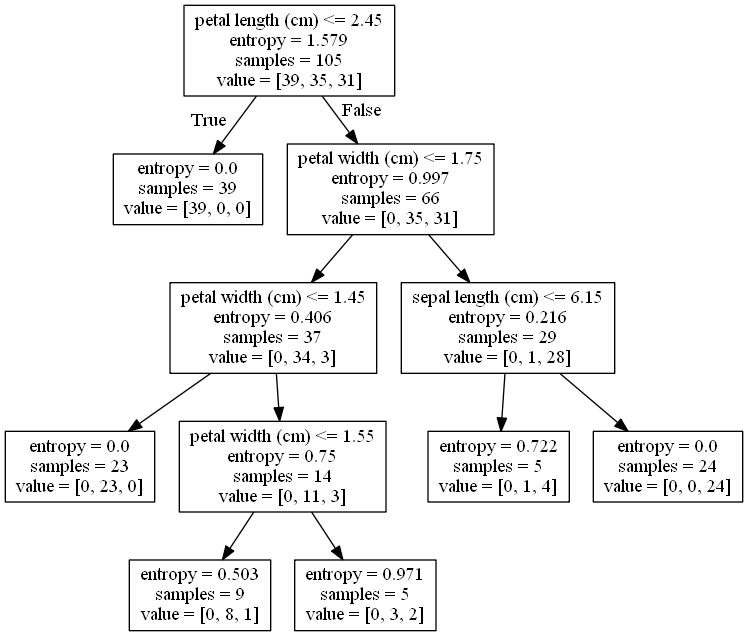

In [24]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(clf, out_file = dot_data, feature_names = feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("tree.png")
Image(graph.create_png())

In [27]:
from sklearn import metrics
def measure_performance(x,y,clf, show_accuracy=True,show_classification_report=True, show_confussion_matrix=True):
    y_pred=clf.predict(x)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)), "\n")

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred), "\n")

    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")


measure_performance(x_train, y_train, clf)

Accuracy:0.962 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        39
          1       0.92      0.97      0.94        35
          2       0.97      0.90      0.93        31

avg / total       0.96      0.96      0.96       105
 

Confussion matrix
[[39  0  0]
 [ 0 34  1]
 [ 0  3 28]] 



['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']
['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1
['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1
Cateorical classes: ['female' 'male']
Integer classes: [0 1]
['pclass' 'age' 'sex']
['1st' '31.19418104265403' '0'] 1
Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]
['age', 'sex', 'first class', 'second class', 'third class']
[ 29.   0.   1.   0.   0.] 1.0


C:\Users\masayoshi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy:0.822 

Classification report
             precision    recall  f1-score   support

        0.0       0.80      0.97      0.88       643
        1.0       0.90      0.55      0.68       341

avg / total       0.84      0.82      0.81       984
 

Confussion matrix
[[622  21]
 [154 187]] 

Accuracy:0.857 

Classification report
             precision    recall  f1-score   support

        0.0       0.84      0.97      0.90       643
        1.0       0.92      0.64      0.76       341

avg / total       0.87      0.86      0.85       984
 

Confussion matrix
[[624  19]
 [122 219]] 

MSE train : 1.505, test : 18.948
MSE train : 0.982, test : 0.772


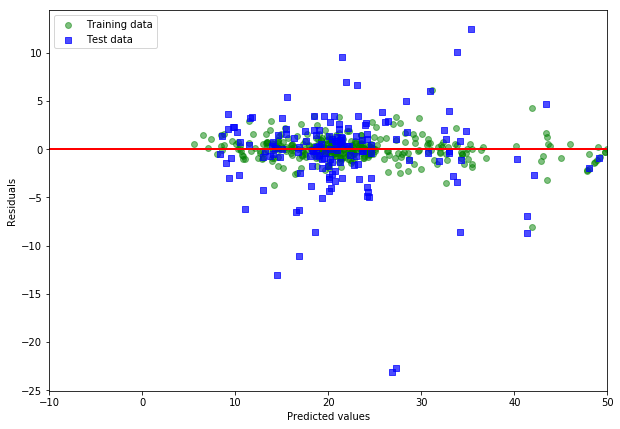

In [1]:
import csv
import numpy as np

with open('./titanic.csv','r') as csvfile:
    titanic_reader = csv.reader(csvfile,delimiter=',',quotechar='"')

    #特徴量の名前が書かれたHeaderを読み取る
    row = next(titanic_reader)
    feature_names = np.array(row)

    #データと正解ラベルを読み取る
    titanic_x, titanic_y = [],[]
    for row in titanic_reader:
        titanic_x.append(row)
        titanic_y.append(row[2]) #正解ラベルは3列目の"survived"

    titanic_x = np.array(titanic_x) #型をリストからnumpy.ndarrayにする
    titanic_y = np.array(titanic_y) #型をリストからnumpy.ndarrayにする

print(feature_names)
print(titanic_x[0],titanic_y[0])


#class(1),age(4),sex(10)を残す
titanic_x = titanic_x[:,[1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]

print(feature_names)
print(titanic_x[12],titanic_y[12])


#年齢の欠損値を平均値で埋める
ages = titanic_x[:,1]
#NA以外のageの平均値を計算する
mean_age = np.mean(titanic_x[ages != 'NA',1].astype(float))
#ageがNAのものを平均値に置き換える
titanic_x[titanic_x[:, 1] == 'NA',1] =mean_age


from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x[:, 2])
print('Cateorical classes:',label_encoder.classes_)

integer_classes = label_encoder.transform(label_encoder.classes_)
print('Integer classes:',integer_classes)

t = label_encoder.transform(titanic_x[:, 2])
titanic_x[:,2] = t

print(feature_names)
print(titanic_x[12],titanic_y[12])


from sklearn.preprocessing import OneHotEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_x [:, 0])
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1)
print("Integer classes:", integer_classes)
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)

#最初に、Label Encoderを使ってpclassを0-2に直す
num_of_rows = titanic_x.shape[0]
t = label_encoder.transform(titanic_x[:, 0]).reshape(num_of_rows, 1)
#次に、OneHotEncoderを使ってデータを1, 0に変換
new_features = one_hot_encoder.transform(t)
#1,0になおしてデータを統合する
titanic_x = np.concatenate([titanic_x, new_features.toarray()], axis = 1)
#OnehotEncoderをする前のpclassのデータを削除する
titanic_x = np.delete(titanic_x, [0], 1)
#特徴量の名前を更新する
feature_names = ['age', 'sex', 'first class', 'second class', 'third class']

# Convert to numerical values
titanic_x = titanic_x.astype (float)
titanic_y = titanic_y.astype (float)

print(feature_names)
print(titanic_x[0],titanic_y[0])

from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.25, random_state=0)


from sklearn import metrics
def measure_performance(x,y,clf, show_accuracy=True,show_classification_report=True, show_confussion_matrix=True):
    y_pred=clf.predict(x)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)), "\n")

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred), "\n")

    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth= 3, min_samples_leaf = 5)
clf = clf.fit(x_train, y_train)

import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names = ['age','Sex','1st_c1ass','2nd_class','3rd_class'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree.pdf")

#決定木モデルの評価
measure_performance(x_train, y_train, clf)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30, random_state=0)
clf = clf.fit(x_train, y_train)

#ランダムフォレストモデルの評価
measure_performance(x_train, y_train, clf)


# ======= 回帰 =======
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# データの読み込み
boston = load_boston()
df = DataFrame(boston.data, columns = boston.feature_names)
df['MEDV'] = np.array(boston.target)

# 説明変数及び目的変数
X = df.iloc[:, :-1].values
y = df.loc[:, 'MEDV'].values

# 学習用、検証用データに分割
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.3, random_state = 0)

# モデル構築
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

# 予測値を計算
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# MSEの計算
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )

# R^2の計算
from sklearn.metrics import r2_score
print('MSE train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

# 残差プロット
# %matplotlib inline
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'green', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10, 50])
plt.show()